<a href="https://colab.research.google.com/github/nhquynhhh/IS403_O21_2/blob/week8_hoangmanhthang/Model/FEDformer/DXG_FEDformer_8_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install neuralforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.5/221.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.5/223.5 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.2/812.2 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.9/65.9 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.

In [2]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from neuralforecast import NeuralForecast
from neuralforecast.models import FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/pre_BTC-USD.csv')

Mounted at /content/drive


In [5]:
df['unique_id'] = 'BTC'
df = df.rename(columns={'Close': 'Price'})
df['Date'] = pd.to_datetime(df['Date'])
df['Price'] = df['Price'].astype(float)
df = df[['unique_id', 'Date', 'Price']]
df

,unique_id,Date,Price
0,BTC,2018-03-01,10951.000000
1,BTC,2018-03-02,11086.400391
2,BTC,2018-03-03,11489.700195
3,BTC,2018-03-04,11512.599609
4,BTC,2018-03-05,11573.299805
...,...,...,...
2280,BTC,2024-05-28,68296.218750
2281,BTC,2024-05-29,67578.093750
2282,BTC,2024-05-30,68364.992188
2283,BTC,2024-05-31,67491.414063


In [6]:
df.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df

,unique_id,ds,y
0,BTC,2018-03-01,10951.000000
1,BTC,2018-03-02,11086.400391
2,BTC,2018-03-03,11489.700195
3,BTC,2018-03-04,11512.599609
4,BTC,2018-03-05,11573.299805
...,...,...,...
2280,BTC,2024-05-28,68296.218750
2281,BTC,2024-05-29,67578.093750
2282,BTC,2024-05-30,68364.992188
2283,BTC,2024-05-31,67491.414063


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2285 non-null   object        
 1   ds         2285 non-null   datetime64[ns]
 2   y          2285 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 53.7+ KB


In [8]:
train_data = df[:int(0.7 * int(len(df)))]
test_data = df[int(0.7 * int(len(df))):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1599
Test lenght: 686


In [9]:
train_data

,unique_id,ds,y
0,BTC,2018-03-01,10951.000000
1,BTC,2018-03-02,11086.400391
2,BTC,2018-03-03,11489.700195
3,BTC,2018-03-04,11512.599609
4,BTC,2018-03-05,11573.299805
...,...,...,...
1594,BTC,2022-07-12,19323.914063
1595,BTC,2022-07-13,20212.074219
1596,BTC,2022-07-14,20569.919922
1597,BTC,2022-07-15,20836.328125


In [10]:
model = FEDformer(h=test_len+90,
                 input_size=300,
                 modes=64,
                 hidden_size=128,
                 n_head=8,
                 scaler_type='standard',
                 learning_rate=1e-3,
                 max_steps=200,
                 batch_size=64,
                 windows_batch_size=256
                )

nf = NeuralForecast(
    models=[model],
    freq='D',
)
nf.fit(df=train_data, static_df=None, verbose=True)
forecasts = nf.predict()


INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 279 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:303: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [11]:
train = train_data['y']
test = test_data['y']


train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)


predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [12]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]


In [13]:
print(predict_test.isna().sum())

0


In [14]:
predict_test

0       13295.439453
1       15581.789062
2       17592.128906
3       19512.769531
4       22039.089844
           ...      
681    230022.984375
682    227085.546875
683    225236.500000
684    225178.359375
685    222982.171875
Name: FEDformer, Length: 686, dtype: float32

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape * 100)
print("Root Mean Square Error (RMSE):", rmse)


Mean Absolute Error (MAE): 45693.1282484805
Mean Absolute Percentage Error (MAPE): 137.38640650818655
Root Mean Square Error (RMSE): 55652.14454066895


In [17]:
#  adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)


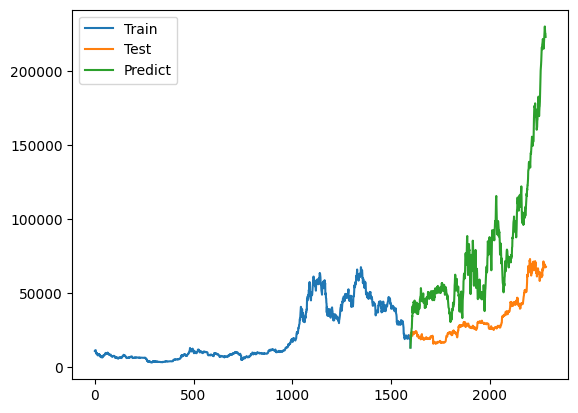

In [21]:
train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)
predict_test_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(predict_test_index,(predict_test))
plt.legend(['Train','Test','Predict'])
plt.show()


In [19]:
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]


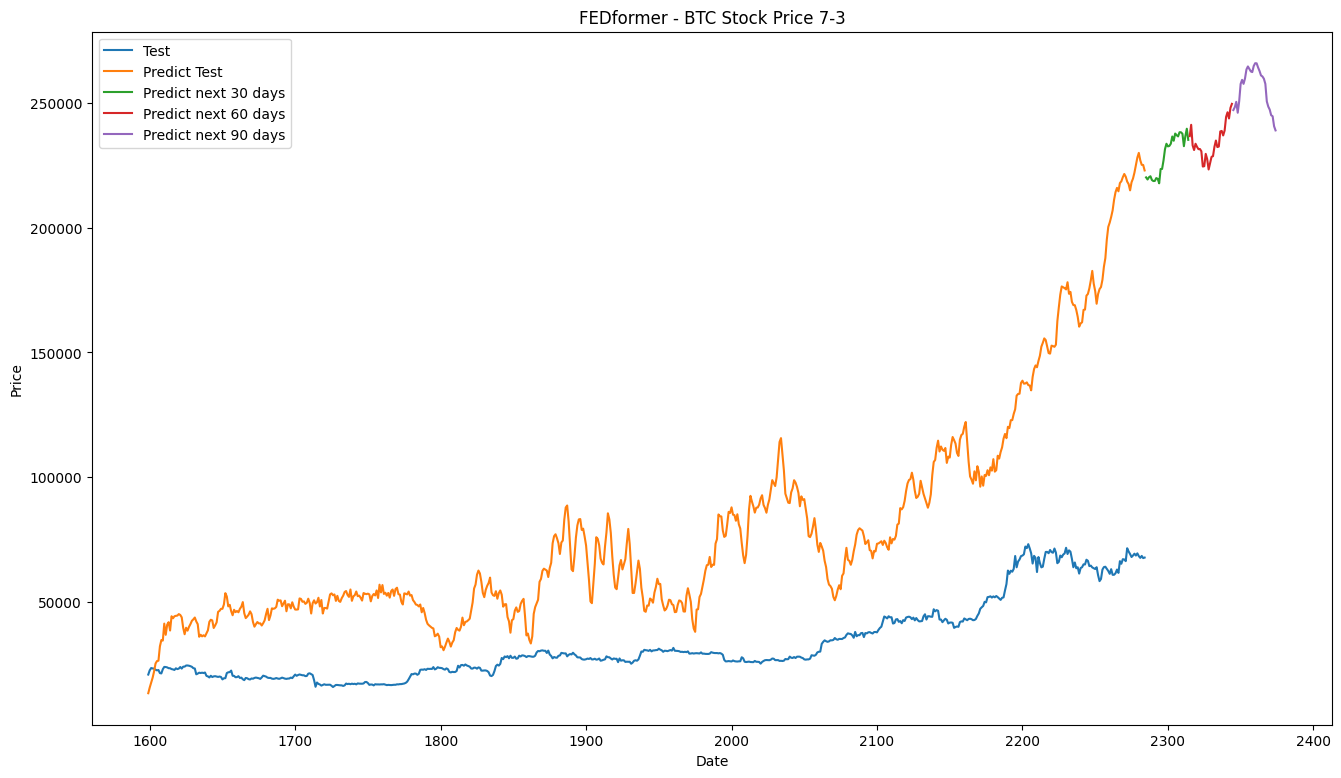

In [20]:
plt.figure(figsize=(16, 9))
# train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
# plt.plot(train_draw)
# test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
# plt.plot(test_data_index, test)
# predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
# plt.plot(predict_test_index,(predict_test))
# predict_future_30_index = pd.RangeIndex(start=train_len[-1]+test_len+1, stop=train_len+test_len+30, step=1)
# plt.plot(predict_future_30_index, predict_future_30)
# predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
# plt.plot(predict_future_60_index, predict_future_60)
# predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
# plt.plot(predict_future_90_index, predict_future_90)


test_data_index = pd.RangeIndex(start=train_len, stop=train_len+len(test_data), step=1)
plt.plot(test_data_index, test, label='Test')

predicted_test_index = pd.RangeIndex(start=train_len, stop=train_len+len(predict_test), step=1)
plt.plot(predicted_test_index, predict_test)

predict_future_30_index = pd.RangeIndex(start=test_data_index[-1]+1, stop=test_data_index[-1]+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)

predict_future_60_index = pd.RangeIndex(start=test_data_index[-1]+31, stop=test_data_index[-1]+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)

predict_future_90_index = pd.RangeIndex(start=test_data_index[-1]+61, stop=test_data_index[-1]+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend([ 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('FEDformer - BTC Stock Price 7-3')
plt.show()
